In [32]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Colab Notebooks/Artificial NN & Deep Learning/Assignment 1

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/Colab Notebooks/Artificial NN & Deep Learning/Assignment 1


In [2]:
!pip install  keras-cv tensorflow
!pip install  keras-cv tensorflow
!pip install  keras

  Using cached keras_cv-0.9.0-py3-none-any.whl.metadata (12 kB)
  Using cached keras_core-0.1.7-py3-none-any.whl.metadata (4.3 kB)
Using cached keras_cv-0.9.0-py3-none-any.whl (650 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 49.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from keras_cv.layers import RandomSaturation
from keras_cv.layers import RandomSharpness
from keras_cv.layers import RandomShear
from keras_cv.layers import Solarization
from keras_cv.layers import Augmenter

In [16]:
file_path = 'Clean_Dataset.npz'

with np.load(file_path) as data:
    training_images = data['images'] #/ 255.0
    training_labels = data['labels']

# Check
print(f"Shape of images: {training_images.shape}")
print(f"type of images: {type(training_images)}")
print(f"shape of labels: {training_labels.shape}")
print(f"type of labels: {type(training_labels)}")
# Dataframe for labels
labels = training_labels.flatten()
df_labels = pd.DataFrame(labels, columns=['label'])
print(df_labels.head())

Shape of images: (11943, 96, 96, 3)
type of images: <class 'numpy.ndarray'>
shape of labels: (11943, 1)
type of labels: <class 'numpy.ndarray'>
   label
0      7
1      3
2      6
3      6
4      7


In [17]:
# train test val split

from sklearn.model_selection import train_test_split

# Define split sizes
test_size = 0.2        # 20% for test
validation_size = 0.2  # 20% of the remaining 80% = 16% for validation

# Split into (training+validation) and test sets
training_labels = training_labels.flatten()
X_train_val, X_test, y_train_val, y_test = train_test_split(
    training_images,
    training_labels,
    test_size=test_size,
    random_state=42,
    stratify=training_labels
)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=validation_size,
    random_state=42,
    stratify=y_train_val
)
print("Training Images - Min pixel value:", np.min(X_train))
print("Training Images - Max pixel value:", np.max(X_train))
print("Validation Images - Min pixel value:", np.min(X_val))
print("Validation Images - Max pixel value:", np.max(X_val))
print("Test Images - Min pixel value:", np.min(X_test))
print("Test Images - Max pixel value:", np.max(X_test))
print("-----------------------------------------------------")
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training Images - Min pixel value: 0
Training Images - Max pixel value: 255
Validation Images - Min pixel value: 0
Validation Images - Max pixel value: 255
Test Images - Min pixel value: 0
Test Images - Max pixel value: 255
-----------------------------------------------------
Training set shape: (7643, 96, 96, 3), (7643,)
Validation set shape: (1911, 96, 96, 3), (1911,)
Test set shape: (2389, 96, 96, 3), (2389,)


In [18]:
#class_counts = np.bincount(training_labels)
class_counts = pd.Series(y_train).value_counts()  # Use only y_train, not the full label set

# `class_counts` now contains the size of each class:
# - `class_counts[j]` gives the count of items with class label `j`.

max_count = class_counts.max()
print(f"Maximum class count: {max_count}")

# Initialize lists to hold oversampled data
X_train_oversampled = []
y_train_oversampled = []

# Iterate through each class to perform oversampling
for class_label in class_counts.index:
    # Current class samples
    X_class = X_train[y_train == class_label]
    y_class = y_train[y_train == class_label]

    # Number of samples to add
    samples_needed = max_count - len(X_class)

    if samples_needed > 0:
        # Calculate how many times to duplicate the class samples
        duplicates = samples_needed // len(X_class)
        remainder = samples_needed % len(X_class)

        # Duplicate the entire class as many times as needed
        for _ in range(duplicates):
            X_train_oversampled.append(X_class)
            y_train_oversampled.append(y_class)

        # Add the remaining samples by randomly selecting from the class
        if remainder > 0:
            indices = np.random.choice(len(X_class), size=remainder, replace=True)
            X_train_oversampled.append(X_class[indices])
            y_train_oversampled.append(y_class[indices])

# Concatenate the oversampled data
if X_train_oversampled:
    X_train_oversampled = np.vstack(X_train_oversampled)
    y_train_oversampled = np.hstack(y_train_oversampled)

    # Append the oversampled data to the original training set
    X_train_balanced = np.vstack((X_train, X_train_oversampled))
    y_train_balanced = np.hstack((y_train, y_train_oversampled))
else:
    # If no oversampling is needed
    X_train_balanced = X_train
    y_train_balanced = y_train

print(f"Training set shape after oversampling: {X_train_balanced.shape}, {y_train_balanced.shape}")

Maximum class count: 1491
Training set shape after oversampling: (11928, 96, 96, 3), (11928,)


In [19]:
import tensorflow as tf
import keras_cv

# Define the augmentation pipeline
augmentation_pipeline = keras_cv.layers.Augmenter([
    keras_cv.layers.RandomSaturation(factor=(0, 1.0)),
    keras_cv.layers.RandomSharpness(factor=(0, 1.0), value_range=[0, 255]),
    keras_cv.layers.RandomShear(
        x_factor=0.3,
        y_factor=0.3,
        interpolation="bilinear",
        fill_mode="reflect",
        fill_value=0.0),
    keras_cv.layers.Solarization(value_range=[0, 255])
])

# Function to apply augmentations
def augment_image(image, label):
    # Convert TensorFlow tensors to NumPy arrays
    image = image.numpy()  # Convert to NumPy for manipulation
    label = label.numpy()  # Convert to NumPy for manipulation

    # Ensure the image is in uint8 format using NumPy
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    # Apply augmentation directly using the Keras CV pipeline
    image = augmentation_pipeline(image)  # Augmentation is directly applied here

    # Convert back to float32 and normalize using TensorFlow operations
    image = tf.cast(image, tf.float32) / 255.0  # Convert to float32 using tf.cast
    image = (image - tf.constant([0.485, 0.456, 0.406])) / tf.constant([0.229, 0.224, 0.225])

    # Ensure label is int32 using tf.cast
    label = tf.cast(label, tf.int32)

    return image, label

# Wrapper function for TensorFlow
def tf_augment_image(image, label):
    # Apply the augment_image function using tf.py_function
    augmented_image, augmented_label = tf.py_function(
        func=augment_image,
        inp=[image, label],
        Tout=[tf.float32, tf.int32]  # Corrected label type to int32
    )

    # Set the shape information
    augmented_image.set_shape((96, 96, 3))
    augmented_label.set_shape(())

    return augmented_image, augmented_label

#print(y_train_balanced.dtype)
#y_train_balanced = y_train_balanced.reshape(-1).astype(np.int32)
#print(y_train_balanced.dtype)

# Create TensorFlow Dataset from balanced training data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_balanced, y_train_balanced))

# Apply the augmentation to the training dataset
train_dataset = train_dataset.map(
    tf_augment_image,
    num_parallel_calls=tf.data.AUTOTUNE
)

# Shuffle, batch, and prefetch for performance
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

In [22]:
# Check the shape of the training dataset and the pixel values
def inspect_training_dataset(dataset):
    # Take a batch from the dataset
    batch = next(iter(dataset))

    # Extract the images from the batch
    images, labels = batch

    # Print the shape of the images and labels
    print(f"Shape of images batch: {images.shape}")
    print(f"Shape of labels batch: {labels.shape}")

    # Print the pixel values of the first image in the batch
    first_image = images[0].numpy()
    print(f"Pixel values of the first image (after augmentation):")
    print(first_image.max(), first_image.min())

# Call the function to inspect the training dataset
inspect_training_dataset(train_dataset)

Shape of images batch: (32, 96, 96, 3)
Shape of labels batch: (32,)
Pixel values of the first image (after augmentation):
2.4285715 -2.117904


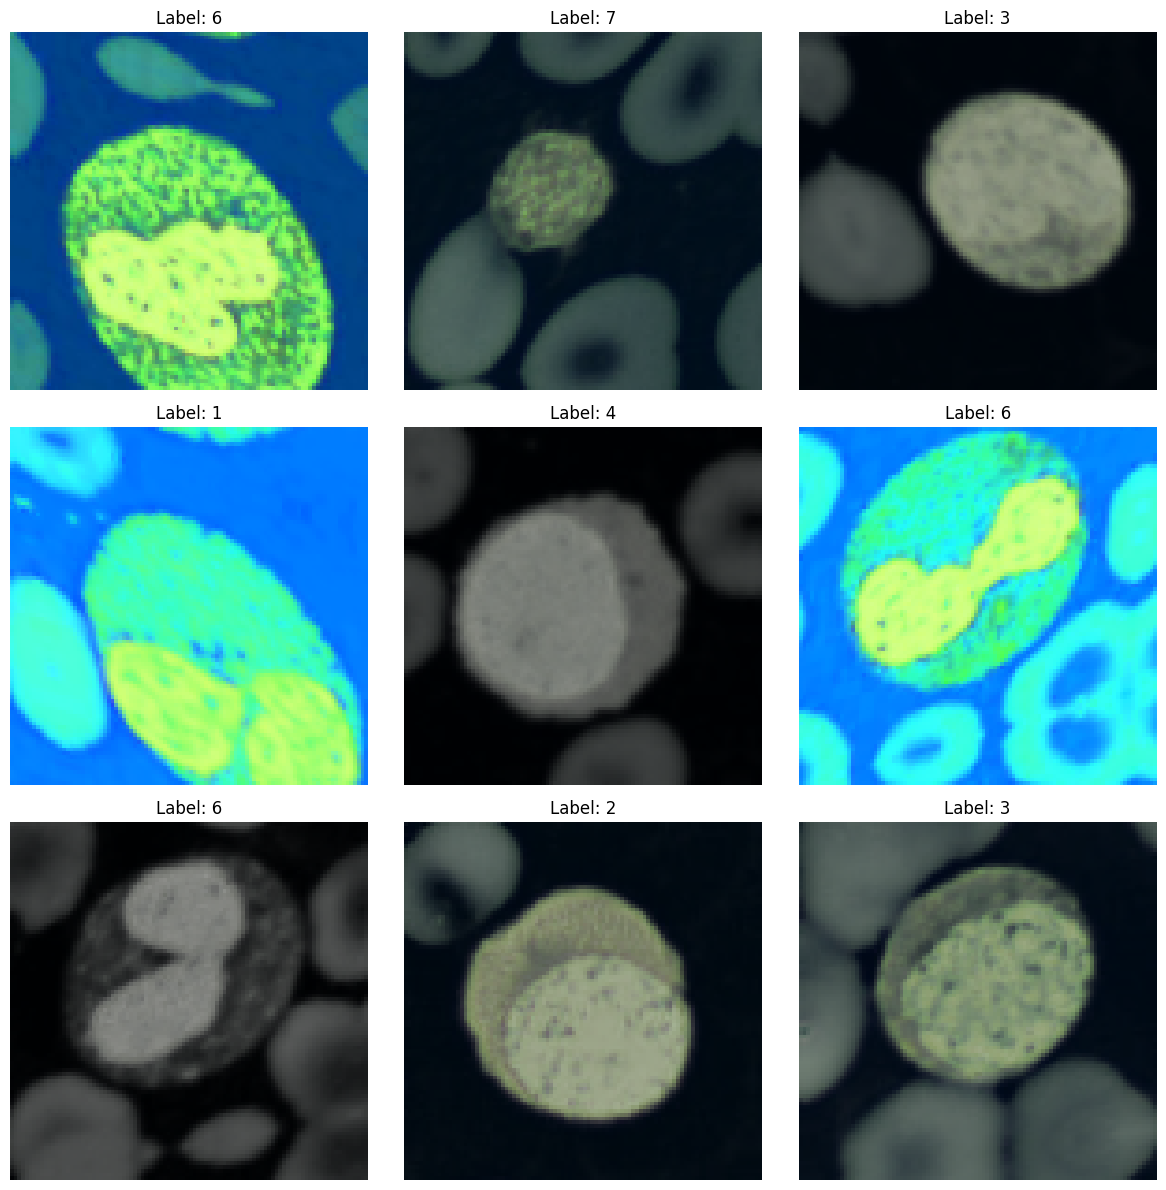

In [23]:
# Function to plot a few augmented images
def plot_augmented_images(dataset, num_images=9):
    # Take a batch from the dataset
    batch = next(iter(dataset))

    # Extract the images and labels from the batch
    images, labels = batch

    # Set up the plot (e.g., 3x3 grid)
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3x3 grid for 9 images
    axes = axes.ravel()  # Flatten the 2D array of axes

    # Plot each image
    for i in range(num_images):
        image = images[i].numpy()  # Convert tensor to numpy array for plotting

        # Reverse normalization for proper display
        image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
        image = np.clip(image, 0, 1)  # Ensure the pixel values are within [0, 1]

        # Plot the image
        axes[i].imshow(image)
        axes[i].axis('off')  # Hide axes
        axes[i].set_title(f"Label: {labels[i].numpy()}")  # Show the label

    plt.tight_layout()
    plt.show()

# Call the function to plot the augmented images
plot_augmented_images(train_dataset)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_resnet_v2 (Functional)     │ (None, 8, 8, 1536)          │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │          12,296 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,349,032 (207.33 MB)

 Trainable params: 12,296 (48.03 KB)

 Non-trainable params: 54,336,736 (207.28 MB)

Epoch 1/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 89s 573ms/step - accuracy: 0.4458 - loss: 1.6112 - val_accuracy: 0.1277 - val_loss: 4.7920 - learning_rate: 0.0010
Epoch 2/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 178ms/step - accuracy: 0.4374 - loss: 2.4659 - val_accuracy: 0.1570 - val_loss: 3.9002 - learning_rate: 0.0010
Epoch 3/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 181ms/step - accuracy: 0.4923 - loss: 1.9253 - val_accuracy: 0.1894 - val_loss: 3.3718 - learning_rate: 0.0010
Epoch 4/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 177ms/step - accuracy: 0.5345 - loss: 1.6660 - val_accuracy: 0.2282 - val_loss: 2.9982 - learning_rate: 0.0010
Epoch 5/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 176ms/step - accuracy: 0.5680 - loss: 1.4888 - val_accuracy: 0.2737 - val_loss: 2.7218 - learning_rate: 0.0010
Epoch 6/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 178ms/step - accuracy: 0.5991 - loss: 1.3587 - val_accuracy: 0.3077 - val_loss: 2.5060 - learning_rate: 0.0010
Epoch 7/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 177ms/step - accuracy: 0.6274 - l

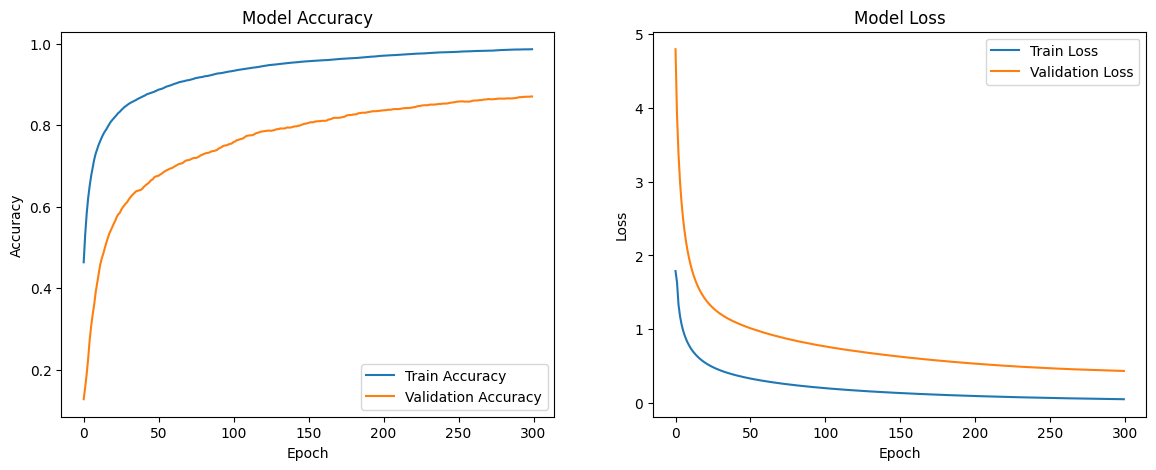

In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras import mixed_precision
import matplotlib.pyplot as plt
import numpy as np

# Enable mixed precision ?
#policy = mixed_precision.Policy('float32')
#mixed_precision.set_global_policy(policy)

# requirements for inceptionresnetv2
input_shape = (299, 299, 3)
inputs = layers.Input(shape=input_shape)

base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)

# Freeze
base_model.trainable = False

# only gap and dense classifier
x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)  #
outputs = layers.Dense(8, activation='softmax', dtype='float32')(x)  # 8 classes

model = models.Model(inputs, outputs)

model.summary()

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = callbacks.ModelCheckpoint(
    'best_inception_resnet_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

callback_list = [early_stop, model_checkpoint, reduce_lr]

def preprocess(image, label):
    image = tf.image.resize(image, [299, 299])
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)  # InceptionResNetV2's preprocess_input, does this normalize automatically?
    label = tf.cast(label, tf.int32)
    return image, label

batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_balanced, y_train_balanced))
train_dataset = train_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Train the model
epochs = 300
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=callback_list,
)


plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [25]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [26]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 844ms/step - accuracy: 0.8601 - loss: 0.5059
Test Loss: 0.48828911781311035
Test Accuracy: 0.8689828515052795


19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 627ms/step


<Figure size 1000x800 with 0 Axes>

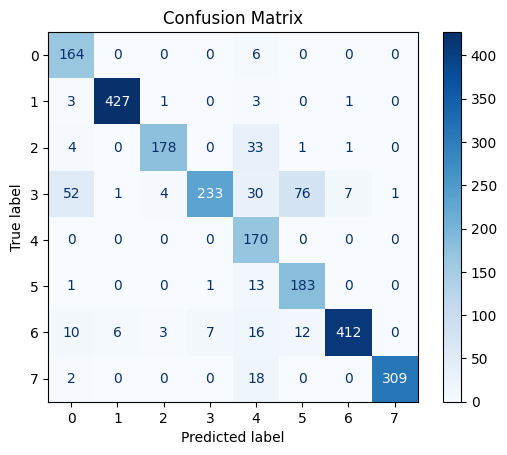

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Generate Predictions
y_pred = model.predict(test_dataset)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Step 2: Calculate the Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Step 3: Plot the Confusion Matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(8))  # Assuming 8 classes
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


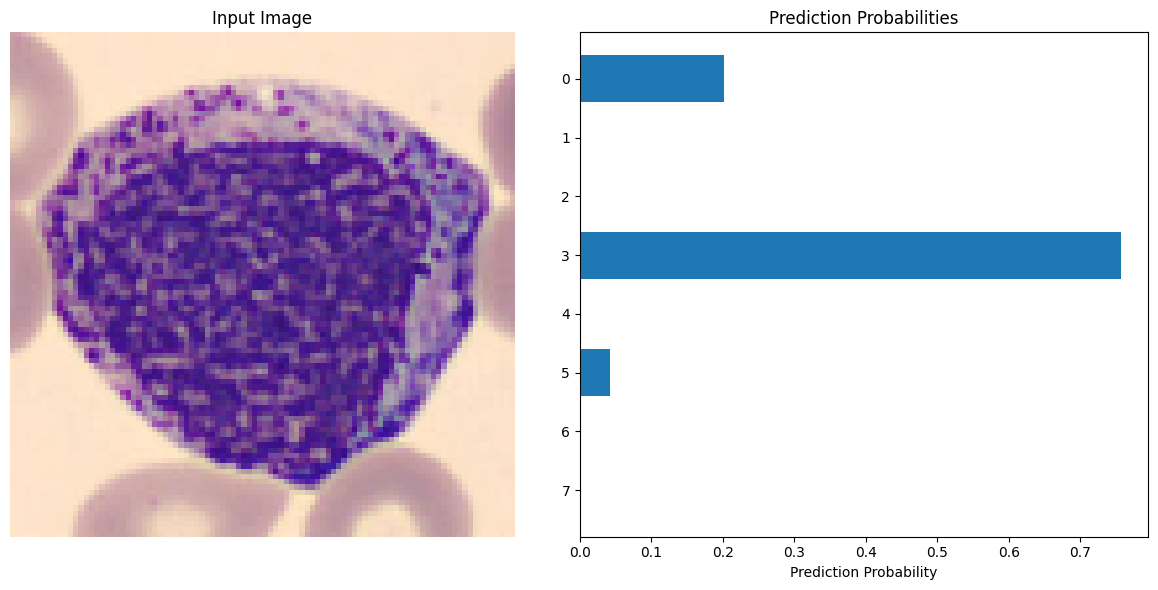

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as tfk

def plot_image_with_prediction(image, model, class_names):
    # Preprocess the image for model prediction
    preprocessed_image = tf.image.resize(image, (299, 299))  # resize for InceptionResNetV2
    preprocessed_image = tf.expand_dims(preprocessed_image, axis=0)  # add batch dimension
    preprocessed_image = tf.keras.applications.inception_resnet_v2.preprocess_input(preprocessed_image)

    # Get prediction probabilities
    prediction = model.predict(preprocessed_image)[0]

    # Set up the plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the image
    axes[0].imshow(image / 255.0)  # Assuming image is in uint8 format
    axes[0].axis('off')
    axes[0].set_title("Input Image")

    # Plot the prediction probabilities as a bar chart
    bar_positions = np.arange(len(class_names))
    axes[1].barh(bar_positions, prediction, align='center')
    axes[1].set_yticks(bar_positions)
    axes[1].set_yticklabels(class_names)
    axes[1].invert_yaxis()  # Highest probability at the top
    axes[1].set_xlabel("Prediction Probability")
    axes[1].set_title("Prediction Probabilities")

    plt.tight_layout()
    plt.show()

#
image = X_test[1]
model = tfk.models.load_model('AUGMENTED_NOE.keras')
class_names = ["0", "1", "2", "3", "4", "5", "6", "7"]
plot_image_with_prediction(image, model, class_names)

## To save :

In [28]:
model.save('weights.keras')
del model

In [29]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        X /= 255.0
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py
